In [117]:
import numpy as np
import pandas as pd                   
import matplotlib.pyplot as plt       
import seaborn as sns
from pyspark.ml.feature import VectorAssembler

In [58]:
df = spark.read.csv("file:///home/amit/Downloads/advertising.csv",inferSchema=True,header=True).drop('Timestamp')

In [59]:
df.show(5)

+------------------------+---+-----------+--------------------+--------------------+--------------+----+----------+-------------+
|Daily Time Spent on Site|Age|Area Income|Daily Internet Usage|       Ad Topic Line|          City|Male|   Country|Clicked on Ad|
+------------------------+---+-----------+--------------------+--------------------+--------------+----+----------+-------------+
|                   68.95| 35|    61833.9|              256.09|Cloned 5thgenerat...|   Wrightburgh|   0|   Tunisia|            0|
|                   80.23| 31|   68441.85|              193.77|Monitored nationa...|     West Jodi|   1|     Nauru|            0|
|                   69.47| 26|   59785.94|               236.5|Organic bottom-li...|      Davidton|   0|San Marino|            0|
|                   74.15| 29|   54806.18|              245.89|Triple-buffered r...|West Terrifurt|   1|     Italy|            0|
|                   68.37| 35|   73889.99|              225.58|Robust logistical...|  Sout

In [60]:
df = df.dropna()

In [61]:
df.printSchema()

root
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Area Income: double (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Ad Topic Line: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Clicked on Ad: integer (nullable = true)



In [62]:
df.dtypes

[('Daily Time Spent on Site', 'double'),
 ('Age', 'int'),
 ('Area Income', 'double'),
 ('Daily Internet Usage', 'double'),
 ('Ad Topic Line', 'string'),
 ('City', 'string'),
 ('Male', 'int'),
 ('Country', 'string'),
 ('Clicked on Ad', 'int')]

In [63]:
categorical_columns=['Clicked on Ad','Male']
numeric_columns=[]
for col,datatype in df.dtypes:
    if datatype == 'string':
        categorical_columns.append(col)
    elif col not in categorical_columns:
        numeric_columns.append(col)

In [64]:
categorical_columns

['Clicked on Ad', 'Male', 'Ad Topic Line', 'City', 'Country']

In [65]:
numeric_columns

['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

In [68]:
dataframe = df.toPandas()

In [72]:
x = df.select('Area Income','Age')

In [73]:
y = df.select('Clicked on Ad')

In [75]:
feature = VectorAssembler(inputCols=['Area Income','Age'],outputCol='features')

In [77]:
final_data  = feature.transform(df)

In [80]:
final_data = final_data.select('features','Clicked on Ad')

In [82]:
final_data.show(5)

+---------------+-------------+
|       features|Clicked on Ad|
+---------------+-------------+
| [61833.9,35.0]|            0|
|[68441.85,31.0]|            0|
|[59785.94,26.0]|            0|
|[54806.18,29.0]|            0|
|[73889.99,35.0]|            0|
+---------------+-------------+
only showing top 5 rows



In [85]:
train,test = final_data.randomSplit([0.75,0.25])

In [86]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Clicked on Ad', maxIter=10)
lrModel = lr.fit(train)

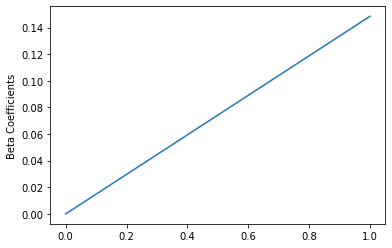

In [87]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/home/amit/Downloads/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


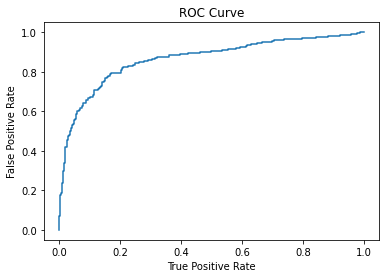

Training set areaUnderROC: 0.8641898108216893


In [116]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/home/amit/Downloads/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


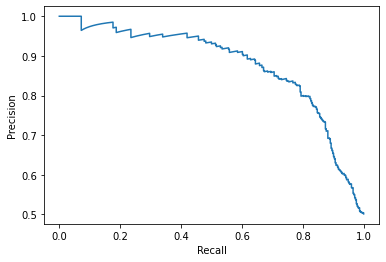

In [89]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [93]:
predictions = lrModel.transform(test)
predictions.show(10)

+---------------+-------------+--------------------+--------------------+----------+
|       features|Clicked on Ad|       rawPrediction|         probability|prediction|
+---------------+-------------+--------------------+--------------------+----------+
|[15598.29,45.0]|            1|[-5.6432166714991...|[0.00352896068938...|       1.0|
|[18368.57,36.0]|            1|[-4.0222064843104...|[0.01759815299679...|       1.0|
|[20856.54,38.0]|            1|[-4.0639365651268...|[0.01689104148473...|       1.0|
|[22456.04,33.0]|            1|[-3.1571713185629...|[0.04080963636141...|       1.0|
|[23942.61,43.0]|            1|[-4.4898622359654...|[0.01109764978592...|       1.0|
|[24030.06,44.0]|            1|[-4.6294124734172...|[0.00966614562979...|       1.0|
|[24078.93,38.0]|            1|[-3.7332505140335...|[0.02335640558383...|       1.0|
| [24852.9,41.0]|            1|[-4.0993980850991...|[0.01631215492778...|       1.0|
|[25371.52,35.0]|            1|[-3.1550297408578...|[0.0408935492

In [114]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator().setLabelCol("Clicked on Ad")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9001736111111112
